# Marvel Universe Network Analysis

## MOTIVATION
Marvel Universe is a fictional universe created by Stan Lee and other artists since 1961. Throughout the years, more than eight-thousand characters have been built within this universe which consists of marvelous superhero teams such as the Avengers, the X-Men, S.H.I.E.L.D., etc. There are superheroes including Captain America, Spider-man, Iron Man, Doctor Strange, Black Panther and many more. Those superheroes and superhero teams have gained worldwide popularity and become cultural icons via recent blockbuster film series (**The Avengers**), enabling Marvel to be a pioneer of transmedia storytelling in the modern media. Having huge respect for the creators and being fascinated with the characters and stories, we want to take this project as a chance to share our interest in Marvel Universe and apply social network analysis to visualize and understand the connections among superheroes.

## OBJECTIVES
By conducting this project, we wanted to use the concepts learned in the class regrading Graph Theory to do a social network analysis on Marvel Universe. In particular, the project's objectives includes:
- Produce graphs to demonstrate the connections among superheroes.
- Identify any communities/clusters within Marvel Universe according to the features provided. 
- Analyze the robustness of Marvel heroes network.


## RESEACH QUESTIONS
- How many communities/clusters are presented in the network?
- Who are the top heroes in the Marvel Universe? (Top 100, Top 30 heroes )
- Who are the connectors in the Marvel Universe? 
- How strong is the Marvel heroes network? (Analyze the network robustness)


## EXPLORATORY DATA ANALYSIS

The dataset consists of information about relationships among the characters in the Marvel Universe, including three small different sets such as: 
- hero-network.csv contains information about relationship among heores and characters in the Marvel Unvierse.
- edges.csv contains information of the comic volumns where the interaction between two characters happened.
- nodes.csv indicates the name and the type of the nodes (hero or comic).

### The dataset:

In [1]:
#Install needed packages

pip install networkx
pip install --upgrade networkx
pip install matplotlib
pip install community
pip install plotly
pip install ipykernel
pip install --upgrade nbformat
pip install python-louvain

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from community import community_louvain
import matplotlib.cm as cm

In [3]:
hero_net_df = pd.read_csv('hero-network.csv')
hero_net_df

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE /
574464,CALLISTO,CALIBAN/
574465,CALIBAN/,ROGUE /


It can be seen that hero-network.csv contains inforamtion about connection among Marvel characters. The dataset has 574,467 rows and 2 columns meaning there are 574,467 interactions between a set of characters. Generally, whenever a character interacted the other in the a comic book, this event is counted as an input in this file. For example, when IRON MAN initiated an interaciton with CAPTAIN AMERICA, it is counted as an input having IRON MAN as hero1 and CAPTAIN AMERICA as hero2. In contrast, if CAPTAIN AMERICA initiated an interaction with IRON MAN, then we have an input having CAPTAIN AMERICA as hero1 and IRON MAN as hero2.

In [4]:
edge_df = pd.read_csv('edges.csv')
edge_df

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


There are 96,104 rows and 2 columns in edges.csv. Each row contains information of who are the 2 heroes that had an interaction in which Marvel Comics volumns. For example, in row 1, we can see that 24-Hour Man had an interaction with Emmanuel in the comic book AA2 35.

In [5]:
nodes_df = pd.read_csv('nodes.csv')
nodes_df

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
...,...,...
19085,"ZOTA, CARLO",hero
19086,ZOTA,hero
19087,ZURAS,hero
19088,ZURI,hero


There are 19,090 rows and 2 columns in nodes.csv. Each row includes the name and the type of a node. There are two type of node - comic and hero. Next step, we conducted data preposessing to make the dataset's format consistent before constructing the network.

Let's find out the total number of characters we have in this dataset:

In [6]:
# Each name is counted only 1 time
all_characters = set()

for row in hero_net_df.index:
    all_characters.add(hero_net_df["hero1"][row])
    all_characters.add(hero_net_df["hero2"][row])
    
print("There are ", len(all_characters), "characters in Marvel Universe.")

There are  6426 characters in Marvel Universe.


At this step, we found that the names listed in the dataset are not only heroes names but also other characters names.

### DATA PREPROCESSING

**Hero name:**

Firstly, we found that the characters names in hero-name.csv and edges.csv are not consistent. For example, in hero-network.csv, Spiderman (Peter Parker) was input as SPIDER-MAN/PETER PAR while as SPIDER-MAN/PETER PARKER in edges.csv. The characters' names in edges.csv are also longer than ones in hero-network.csv. Hence, to make the format consistent, we limited the length of name in both files as 20 characters and used only strings on the left based on the slash "/". 

In [7]:
tempdata = pd.DataFrame({'edges.csv':sorted([h for h in edge_df['hero'].unique() if 'SPIDER' in h]),
                     'hero-network.csv':sorted([h for h in hero_net_df['hero1'].unique() if 'SPIDER' in h])})

display(tempdata)

# Preprocessing heroes names: use length as 20; only left string based on "/" 
for c in ['hero1', 'hero2']:
    hero_net_df[c] = hero_net_df[c].apply(lambda x : x[:20].split("/")[0])
edge_df['hero'] = edge_df['hero'].apply(lambda x : x[:20].split("/")[0])

,edges.csv,hero-network.csv
0,"BEACH, SPIDER","BEACH, SPIDER"
1,BLOOD SPIDER/,BLOOD SPIDER/
2,MAN-SPIDER CLONE | M,MAN-SPIDER CLONE | M
3,MAN-SPIDER | MUTANT,MAN-SPIDER | MUTANT
4,SPIDER-MAN CLONE/BEN,SPIDER-MAN CLONE/BEN
5,SPIDER-MAN III/MARTH,SPIDER-MAN III/MARTH
6,SPIDER-MAN/PETER PARKER,SPIDER-MAN/PETER PAR
7,SPIDER-WOMAN DOPPELG,SPIDER-WOMAN DOPPELG
8,SPIDER-WOMAN II/JULI,SPIDER-WOMAN II/JULI
9,SPIDER-WOMAN IV/CHAR,SPIDER-WOMAN IV/CHAR


**Reconstruct data:**

We need to reconstruct the dataset before creating the network. Specifically, a node represents a hero and an edge demonstrates the number of comic books in which two heroes appeared together.
Let's take a close look at the top 100 heroes who have the highest number of interactions within the network as a start.

In [8]:
topn = 100
topn_hero = edge_df.groupby(['hero'])[['comic']].count().sort_values(by=['comic'], ascending=False).head(topn).index

h1_ = []; h2_ = []; cnt_ = [];
for comb in list(combinations(topn_hero, 2)):    
    temp1 = set(edge_df[edge_df['hero']==comb[0]]['comic'])
    temp2 = set(edge_df[edge_df['hero']==comb[1]]['comic'])
    cnt = len(temp1.intersection(temp2)) # Appear Together    
    h1_.append(comb[0]); h2_.append(comb[1]); cnt_.append(cnt);
appto_df = pd.DataFrame({'H1':h1_, 'H2':h2_, 'CNT':cnt_})

display(appto_df)

,H1,H2,CNT
0,SPIDER-MAN,CAPTAIN AMERICA,145
1,SPIDER-MAN,IRON MAN,95
2,SPIDER-MAN,THING,125
3,SPIDER-MAN,THOR,96
4,SPIDER-MAN,HUMAN TORCH,147
...,...,...,...
4945,TIGRA,"PAGE, KAREN",0
4946,TIGRA,NAMORITA,3
4947,SPIDER-MAN CLONE,"PAGE, KAREN",0
4948,SPIDER-MAN CLONE,NAMORITA,2


## SOCIAL NETWORK ANALYSIS

### Network Communities:

Firstly, based on the recontructed data, we created a initial graph to have an overview of the cumminities in the Top 100 Heroes network.

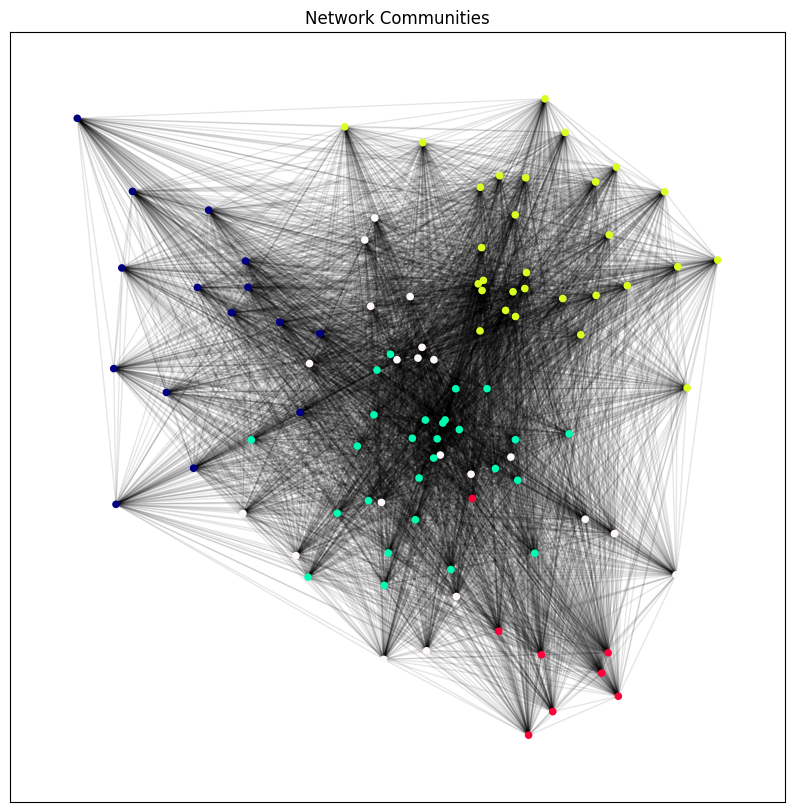

In [9]:
# Create network
marvel_nw = nx.Graph() 
for i, row in appto_df.iterrows():
    marvel_nw.add_edge(row['H1'], row['H2'], weight=row['CNT'])

# Extract connected nodes to visualize
Graph = marvel_nw.subgraph(sorted(nx.connected_components(marvel_nw), key=len, reverse=True)[0])

# Community division
partition_hero = community_louvain.best_partition(Graph)

# Color the nodes according to communities
cmap = cm.get_cmap('gist_ncar', max(partition_hero.values()) + 1)

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(Graph, seed=42)
nx.draw_networkx_nodes(Graph, pos, partition_hero.keys(), node_size=20, alpha=1,
                       cmap=cmap, node_color=list(partition_hero.values()))
nx.draw_networkx_edges(Graph, pos, alpha=0.1)
plt.title("Network Communities")
plt.show()

At this initial stage, it can be seen that the network is relatively dense which is challenging to visualize the relationships among heroes. However, based on the colors of nodes, we can see that there are five communities presented in this network: red, blue, yellow, cyan and white. This infers that the heroes in the same communities share similar attributes. In a communitiy, any hero has interaction to others within this community but not necessarily has interaction to heroes in other communities. Some heroes interact with various communities could play the role of the leader in their communities.

### The Top 100 & Top 30 Heroes Networks:

At this preliminary stage, based on the colors of nodes, we can see that there are five communities presented in this network: red, blue, yellow, cyan and white. In a communitiy, any hero has interaction with others within this community but not necessarily has interaction with heroes from other communities. The heroes who have interactions across various communities could play the role of leaders in these communities. We also want to visualize the relationships among heroes within the communities with more details in the following steps.

In [10]:
# Get positions for the nodes in network
pos_ = nx.spring_layout(marvel_nw, seed=11)
cent_ = nx.pagerank(marvel_nw, weight='weight') # page rank
cent_top = sorted(cent_.items(), key=lambda item: item[1], reverse=True)[:1] # page rank top 1


# Custom function to create an edge between node x and node y, with text and width
def make_edge(x, y, text, width):
    return  go.Scatter(x=x, y=y, line=dict(width=width, color='lightgray'), hoverinfo='text', text=([text]), mode='lines')

# For each edge, make an edge_trace, append to list
edge_trace = []
for edge in marvel_nw.edges():    
    if marvel_nw.edges()[edge]['weight'] > 0:
        char_1 = edge[0]
        char_2 = edge[1]
        x0, y0 = pos_[char_1]
        x1, y1 = pos_[char_2]
        trace  = make_edge([x0, x1, None], [y0, y1, None], None, width=5*(marvel_nw.edges()[edge]['weight']/appto_df['CNT'].max()))
        edge_trace.append(trace)
                
# Make a node trace
node_trace = go.Scatter(x=[], y=[], text=[], textposition="top center", textfont_size=10, mode='markers+text', hoverinfo='none',
                        marker=dict(color=[], size=[], line_width=[], line_color=[]))
HERO_COLOR = {
    'CAPTAIN AMERICA':'darkblue',
    'IRON MAN':'gold',
    'SPIDER-MAN':'darkred',
    'HULK':'forestgreen',
    'THOR':'lightblue',
    'DR. STRANGE':'purple',
    'BLACK WIDOW':'brown',
    'ANT-MAN':'orange',
    'HAWKEYE':'slategrey',
    'SCARLET WITCH':'blueviolet',
    'VISION':'tomato',
    'CAPTAIN MARVEL':'lime',
    'FALCON':'aqua',
    'BLACK PANTHER':'black'
}

# With each node in marvel_nw, get the position and size and add to the node_trace
for node in marvel_nw.nodes():
    x, y = pos_[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    color = 'gray'
    line_width = 2
    line_color = 'darkgray'
    name_text = node
    
    if node in HERO_COLOR:
        color = HERO_COLOR[node]; line_color='black';
        
    if node in [v[0] for v in cent_top]:
        name_text = '<b>' + node + '</b>'
        
    node_trace['marker']['color'] += tuple([color])
    node_trace['marker']['size'] += tuple([int(400*cent_[node])]) # node size is proportional to page rank
    node_trace['marker']['line_width'] += tuple([line_width])
    node_trace['marker']['line_color'] += tuple([line_color])
    node_trace['text'] += tuple([name_text])
    
# Edit layout
layout = go.Layout(
    width=800,
    height=800,
    paper_bgcolor='rgba(0,0,0,0)', # transparent background
    plot_bgcolor='rgba(0,0,0,0)', # transparent 2nd background
    xaxis =  {'showgrid': False, 'zeroline': False}, # no gridlines
    yaxis = {'showgrid': False, 'zeroline': False}, # no gridlines
)

# Create network
fig = go.Figure(layout = layout)
## Add all edge traces
for trace in edge_trace:
    fig.add_trace(trace)
fig.add_trace(node_trace)
fig.update_layout(showlegend = False)
fig.update_xaxes(showticklabels = False)
fig.update_yaxes(showticklabels = False)
fig.update_layout(title=f"<b>Top {topn} Heroes Network</b>")
fig.show()

From the Top 100 Heroes network, it was still difficult for us to visualize the network, especially the conenction among heroes. Based on the colors and node size, it can be seen that some members of The Avengers have a great numbers of connections. Let's find out who they are by reducing the top 100 to 30. 

In [11]:
topn2 = 30
topn_hero2 = edge_df.groupby(['hero'])[['comic']].count().sort_values(by=['comic'], ascending=False).head(topn2).index

h1n = []; h2n= []; cntn = [];
for comb in list(combinations(topn_hero2, 2)):    
    temp1 = set(edge_df[edge_df['hero']==comb[0]]['comic'])
    temp2 = set(edge_df[edge_df['hero']==comb[1]]['comic'])
    cnt = len(temp1.intersection(temp2)) # Appear Together    
    h1n.append(comb[0]); h2n.append(comb[1]); cntn.append(cnt);
appto_df = pd.DataFrame({'H1n':h1n, 'H2n':h2n, 'CNTn':cntn})

marvel_30 = nx.Graph() 
for i, row in appto_df.iterrows():
    marvel_30.add_edge(row['H1n'], row['H2n'], weight=row['CNTn'])

# Modification
# Get positions for the nodes in network
pos_ = nx.spring_layout(marvel_30, seed=11)
cent_ = nx.pagerank(marvel_30, weight='weight') # page rank
cent_top = sorted(cent_.items(), key=lambda item: item[1], reverse=True)[:1] # page rank top 1


# Custom function to create an edge between node x and node y, with text and width
def make_edge(x, y, text, width):
    return  go.Scatter(x=x, y=y, line=dict(width=width, color='lightgray'), hoverinfo='text', text=([text]), mode='lines')

# For each edge, make an edge_trace, append to list
edge_trace = []
for edge in marvel_30.edges():    
    if marvel_30.edges()[edge]['weight'] > 0:
        char_1 = edge[0]
        char_2 = edge[1]
        x0, y0 = pos_[char_1]
        x1, y1 = pos_[char_2]
        trace  = make_edge([x0, x1, None], [y0, y1, None], None, width=5*(marvel_30.edges()[edge]['weight']/appto_df['CNTn'].max()))
        edge_trace.append(trace)
                
# Make a node trace
node_trace = go.Scatter(x=[], y=[], text=[], textposition="top center", textfont_size=10, mode='markers+text', hoverinfo='none',
                        marker=dict(color=[], size=[], line_width=[], line_color=[]))
HERO_COLOR = {
    'CAPTAIN AMERICA':'darkblue',
    'IRON MAN':'gold',
    'SPIDER-MAN':'darkred',
    'HULK':'forestgreen',
    'THOR':'lightblue',
    'DR. STRANGE':'purple',
    'BLACK WIDOW':'brown',
    'ANT-MAN':'orange',
    'HAWKEYE':'slategrey',
    'SCARLET WITCH':'blueviolet',
    'VISION':'tomato',
    'CAPTAIN MARVEL':'lime',
    'FALCON':'aqua',
    'BLACK PANTHER':'black'
}

# With each node in marvel_30, get the position and size and add to the node_trace
for node in marvel_30.nodes():
    x, y = pos_[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    color = 'gray'
    line_width = 2
    line_color = 'darkgray'
    name_text = node
    
    if node in HERO_COLOR:
        color = HERO_COLOR[node]; line_color='black';
        
    if node in [v[0] for v in cent_top]:
        name_text = '<b>' + node + '</b>'
        
    node_trace['marker']['color'] += tuple([color])
    node_trace['marker']['size'] += tuple([int(400*cent_[node])]) # node size is proportional to page rank
    node_trace['marker']['line_width'] += tuple([line_width])
    node_trace['marker']['line_color'] += tuple([line_color])
    node_trace['text'] += tuple([name_text])
    
    
# Edit layout
layout = go.Layout(
    autosize=False,
    width=800,
    height=800,
    paper_bgcolor='rgba(0,0,0,0)', # transparent background
    plot_bgcolor='rgba(0,0,0,0)', # transparent 2nd background
    xaxis =  {'showgrid': False, 'zeroline': False}, # no gridlines
    yaxis = {'showgrid': False, 'zeroline': False}, # no gridlines
)

# Create network
fig = go.Figure(layout = layout)
## Add all edge traces
for trace in edge_trace:
    fig.add_trace(trace)
fig.add_trace(node_trace)
fig.update_layout(showlegend = False)
fig.update_xaxes(showticklabels = False)
fig.update_yaxes(showticklabels = False)
fig.update_layout(title=f"<b>Top {topn2} Heroes Network</b>")
fig.show()

Finally, we could see that only half of the Avengers team are considered as well-connected heroes. It turned out that Captain American is the most popular heroes as he is represented by the biggest node within the network. Along with Captain American, Spider-Man, Iron Man and Scarlet Witch are also very influential according to their nodes' size. Apart from The Avengers team, other characters such as Mr. Fanstatic, Human Touch, Invisible Women, Thing, Beast and Cyclops also have a great number of interactions with others. 

In the network shown above, we could easily tell that there are three communities which are also the superhero teams in this network. The first communitiy is The Avengers (including Thor, Iron Man, Ant-Man, Vision, Captain America, Hulk, Scarlet Witch, Spiderman and Dr. Strange). The second community is Fanstastic Four located at the center of the graph (including Thing, Mr. Fanstatic, Invisible Woman and Human Touch). Based on edges connecting them, we can see that these four heroes are very associated with each other. The third community is the X-Men which located on the top-left of the graph. 

One more takeaway, the graph conspicuously shows that some heroes such as Captain America, Beast and Spider-Man have the significant roles as connectors to link three commnunities together. In next step, we did computational analysis to to verify this statement.

### Who are the connectors?

In order to find out which heroes play the role of connectors within the network, we performed some calculation inclduing: Degree Centrality, PageRank and Betweeness Centrality.

In [12]:
centrality_df = pd.DataFrame(index=list(marvel_nw.nodes()))

# Compute degree centrality
centrality = {h:0.0 for h in marvel_nw.nodes()}
for u, v, d in marvel_nw.edges(data=True):
    centrality[u]+=d['weight']; centrality[v]+=d['weight'];
centrality_df['w_degree_cent'] = pd.Series(index=[k for k, v in centrality.items()], data=[float(v) for k, v in centrality.items()])

# Compute pagerank
centrality = nx.pagerank(marvel_nw, weight='weight')
centrality_df['w_pagerank_cent'] = pd.Series(index=[k for k, v in centrality.items()], data=[float(v) for k, v in centrality.items()])

# Compute betweenness centrality
centrality = nx.betweenness_centrality(marvel_nw, weight='weight')
centrality_df['w_betweenness_cent'] = pd.Series(index=[k for k, v in centrality.items()], data=[float(v) for k, v in centrality.items()])

display(centrality_df)
centrality_df = centrality_df.drop(columns=['w_betweenness_cent'])

,w_degree_cent,w_pagerank_cent,w_betweenness_cent
SPIDER-MAN,5711.0,0.024952,0.000000e+00
CAPTAIN AMERICA,7801.0,0.029430,0.000000e+00
IRON MAN,6024.0,0.022946,4.878669e-05
THING,5904.0,0.022274,0.000000e+00
THOR,6177.0,0.024564,4.875853e-07
...,...,...,...
"HUDSON, HEATHER",627.0,0.003725,7.860617e+13
TIGRA,1483.0,0.006758,2.166107e+11
SPIDER-MAN CLONE,383.0,0.003053,6.046035e+17
"PAGE, KAREN",466.0,0.003545,6.797760e+13


The Betweeness Centrality calculates the number of times a node performs as a bridge between two other nodes along the shortest path. However, since all heroes in the network are interconnected, the Betweeness Centrality seems not to be useful in our case here. Besides, we cannot make decision based on each centrality index as they have different scales. It is neccessary to make the range consistent before making the comparision. Hence, we decided to use MinMaxScaler first and then calculate the mean centrality. 

In [13]:
from sklearn.preprocessing import MinMaxScaler
# Scaling
for c in centrality_df.columns:
    s = MinMaxScaler()
    centrality_df[[c]] = s.fit_transform(centrality_df[[c]])  
centrality_df['mean_cent'] = centrality_df.mean(axis=1)
centrality_df = centrality_df.sort_values(by=['mean_cent'], ascending=False)

# Create mean centrality chart
fig = go.Figure(data=[go.Bar(
    x=centrality_df.index,
    y=centrality_df['mean_cent'],
)])
fig.update_layout(title_text='<b>Mean Centrality of Top 50 Heroes</b>')

According to the mean centrality chart, we are assured that Captain America is the leading hero of Marvel Universe as his mean centrality is close to 1. Along with Captain America, Spider-Man, Scarlet With and Vision are the connectors in The Avengers community. These heroes have strong connections with other communities and bridge the communities together in the network. Moreover, Thing plays the connector role in the Fanstatic Four community, Beast connects his X-Men community with other groups in Marvel Universe.

### Network's Robustness:

Last but not least, one of our major task is to find out how robust the Marvel heroes network is. Typically, we can measure the robustness of a network by keep removing nodes from the graph to determine when the network would splinter and facture. In our project, we used the function minimum_node_cut of NetworkX to see when the failure point was (the number of node should be removed to make the network collapsed) on the Top 30, Top 50, Top 100 and Top 200 Heroes networks.

In [14]:
# Prepare data for testing
all = {}
allnw = {}
for topn in [30, 50, 100, 200]:
    top_heroes = edge_df.groupby(['hero'])[['comic']].count().sort_values(by=['comic'], ascending=False).head(topn).index
    h1_ = []; h2_ = []; cnt_ = [];
    for comb in list(combinations(top_heroes, 2)):    
         temp1 = set(edge_df[edge_df['hero']==comb[0]]['comic'])
         temp2 = set(edge_df[edge_df['hero']==comb[1]]['comic'])
         cnt = len(temp1.intersection(temp2))    
         h1_.append(comb[0]); h2_.append(comb[1]); cnt_.append(cnt);
    appto_df = pd.DataFrame({'H1':h1_, 'H2':h2_, 'CNT':cnt_})
    all[topn] = appto_df.copy()

    marvel_nw = nx.Graph() 
    for i, row in appto_df.iterrows():
        if row['CNT'] > 0:
            marvel_nw.add_edge(row['H1'], row['H2'], weight=row['CNT'])
    allnw[topn] = marvel_nw.copy()
    
min_node_ = []; r_ = [];
for n in [30, 50, 100, 200]:
    test = all[n].copy()
    test_net = allnw[n].copy()
    cnt = len(nx.minimum_node_cut(test_net))
    min_node_.append(cnt)
    r_.append(cnt/n)
test_df = pd.DataFrame({'Heroes':[30, 50, 100, 200], 'Number of Nodes':min_node_, 'Cutting Node Ratio':r_})

In [15]:
# Create graph
fig = make_subplots(specs=[[{"secondary_y": True}]])
for c in ['Number of Nodes', 'Cutting Node Ratio']:
    temp_ = test_df[c]
    if c == 'Cutting Node Ratio':
        fig.add_trace(go.Scatter(x=[f"In Top {n} Heroes" for n in [30, 50, 100, 200]], y=temp_, name=c, line=dict(color='darkgray')),
                      secondary_y=True)
    else:
        fig.add_trace(go.Bar(x=[f"In Top {n} Heroes" for n in [30, 50, 100, 200]], y=temp_, name=c
                                ))

fig.update_layout(barmode='group')
fig.update_yaxes(title_text="count", secondary_y=False)
fig.update_yaxes(title_text="ratio", secondary_y=True)
fig.update_layout(title_text="<b>Network's Robustness based on the number of heroes</b>")
fig.show()

test = all[100].copy()

From the graph above, Top 30 Heroes network is very robust, all of the 29 heroes are super interconected. 24 nodes must be removed to make this network collapse. For the Top 50 Heroes network, it takes removing 41 nodes to get the network disconnected. In Top 100 Heroes network, removing 40 nodes is the fall-apart point of this network. However, in Top 200 Heroes network, the network will collapse by removing only 7 nodes. This is explicable because majority of the network's nodes have very few connections.

## RESULTS AND CONTEMPLATION

**Conclusion:**

We performed the social network analysis of the Marvel Universe to address the proposed research questions in our final project. We found out that there are five communities within the Marvel Heroes network from the dataset we gathered online. Captain America is the leading hero of Marvel Universe as he is the most well-connected hero in the network. Along with Captain America, Spider-Man, Thing, Scarlet Witch, Vision and Beast are the heroes who connect different superhero teams together. Our robustness analysis of the Top 30, Top 50 and Top 100 Heroes netwroks proves that the network is robust since it takes removing such substantial portion of the nodes to collapse the network. To our surprise, the Top 100 Heroes network is still considered robust. To cause total network splinter, almost half of the nodes need to be removed. We also found out that the robustness of the network decrease as the number of heroes increase. This is because most of the heroes has very few connection or some of them only interact with very well-connected heroes. 

**Future improvement:**

The project could be improved by utilizing some other tools such as Gephi or Neo4j to improve the visualization of the network graph. For example, Gephi's modularity function could help us to better visualize the communities in the network. Apart from adding color to each community, it also helps to identify the members of the commnunity as well as which members are the most connected ones. Having that information could help us understand more about the intra-relationship among Marvel heroes. About the robustness, we could have more indepth results by finding out which nodes to remove to cause the collapse of the network. We would remove the most connected heroes to see how the network look like in response. From this step, we could find out which hero in particular has the most impact on the network. 